In [1]:
import numpy as np
import pandas as pd


from average_atom.core.average_atom import NeutralPseudoAtom as NPA
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from average_atom.core import physics as physics
    from average_atom.core import average_atom as average_atom
    from average_atom.core import misc as misc
    from average_atom.core import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

from scipy.interpolate import interp1d


import cProfile

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14


Error:  name 'physics' is not defined


In [11]:
# Aluminuma
name='Al'
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = 8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)

Ti_eV = 2 
Te_eV = 10

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

####
R = 30*rs
rmin = rs/1000
ignore_vxc = False

aa_kwargs = {'initialize':True, 'gradient_correction':None, 'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin': rmin,'Npoints':600,
             'name':name, 'ignore_vxc':ignore_vxc, 'fixed_Zstar':False, 'iet_R_over_rs':R/rs, 'iet_N_bins':5000, 'use_full_ne_for_nf':False}

npa_kwargs = {'initialize':True, 'gradient_correction':None,'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin':1e-2 ,'Npoints':1000, 
              'name':name,'ignore_vxc':False, 'fixed_Zstar':False, 'iet_R_over_rs':R/rs*3, 'iet_N_bins':5000, 'use_full_ne_for_nf':False}

aa = NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aa_kwargs)
npa = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)
npa_2 = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)

________________________
Generating NPA
Using More TF fit for initial Zstar = 4.052
	Intializing grid
	Creating Integral Equation Solver
Intialized Potentials and Densities
________________________
Generating NPA
Using More TF fit for initial Zstar = 4.052
	Intializing grid
	Creating Integral Equation Solver
	-------------------
	Solving IET.
0: Initial condition Total Error: 6.737e+01
Exiting status 0, reverting to best index so far: 3751
Final iter:3752, Total Error: 9.975e-13
Intialized Potentials and Densities
________________________
Generating NPA
Using More TF fit for initial Zstar = 4.052
	Intializing grid
	Creating Integral Equation Solver
	-------------------
	Solving IET.
0: Initial condition Total Error: 6.737e+01
Exiting status 0, reverting to best index so far: 3751
Final iter:3752, Total Error: 9.975e-13
Intialized Potentials and Densities


In [12]:
%%time
aa.solve_TF(verbose=True, picard_alpha=0.2, num_10folds_per_rs=0.5, tol=1e-7)
aa.set_uii_eff()
aa.iet.HNC_solve(iters_to_wait=1e5, tol=1e-12, verbose=False, num_iterations=1e5)
aa.gii = interp1d(aa.iet.r_array*aa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(aa.grid.xs)
aa.make_ρi()

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =     1.7926, change: 2.5013e+00 (converged=False)
	φe Err = -1.056e-11, φe change =  7.330e-01
	ne Err =  4.307e-01, ne change =  1.765e-03
	Q =  0.000e+00 ->  1.375e+00, 
	Zstar guess =  8.838e+00. Current Zstar:  5.009e+00 (converged=False)
	Change =  2.082e+00
__________________________________________
TF Iteration 1
	mu =     1.3578, change: 2.4257e-01 (converged=False)
	φe Err = -1.064e-11, φe change =  5.810e-02
	ne Err =  3.021e-01, ne change =  1.009e-03
	Q =  1.375e+00 ->  1.260e+00, 
	Zstar guess =  7.306e+00. Current Zstar:  5.469e+00 (converged=False)
	Change =  2.581e-01
__________________________________________
TF Iteration 2
	mu =     1.2504, change: 7.9091e-02 (converged=False)
	φe Err = -6.343e-12, φe change =  2.614e-02
	ne Err =  2.392e-01, ne change =  7.429e-04
	Q =  1.260e+00 ->  1.296e+00, 
	Zstar guess =  6.792e+00. Current

In [6]:
%%time
npa.solve_TF(verbose=True, picard_alpha=0.2, num_10folds_per_rs=0.5, tol=1e-7, nmax = 1000, n_wait_update_Zstar= 200)
npa.set_uii_eff()

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =     0.3771, change: 3.8976e-03 (converged=True)
	φe Err =  6.093e-11, φe change =  7.409e-01
	ne Err =  2.872e-01, ne change =  1.405e-02
	Q =  0.000e+00 ->  0.000e+00, 
	Zstar guess =  0.000e+00. Current Zstar:  2.495e+00 (converged=False)
	Change =  7.131e-01
__________________________________________
TF Iteration 1
	mu =     0.3765, change: 1.3657e-03 (converged=True)
	φe Err =  1.145e-11, φe change =  1.004e-01
	ne Err =  2.384e-01, ne change =  9.117e-03
	Q =  0.000e+00 ->  0.000e+00, 
	Zstar guess =  0.000e+00. Current Zstar:  2.490e+00 (converged=False)
	Change =  1.204e-01
__________________________________________
TF Iteration 2
	mu =     0.3761, change: 1.1855e-03 (converged=True)
	φe Err =  2.042e-12, φe change =  9.074e-02
	ne Err =  1.826e-01, ne change =  5.567e-03
	Q =  0.000e+00 ->  0.000e+00, 
	Zstar guess =  0.000e+00. Current Zs

In [47]:
npa_2 = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)

________________________
Generating NPA
Using More TF fit for initial Zstar = 4.052
	Intializing grid
	Creating Integral Equation Solver
	-------------------
	Solving IET.
0: Initial condition Total Error: 6.737e+01
Exiting status 0, reverting to best index so far: 3751
Final iter:3752, Total Error: 9.975e-13
Intialized Potentials and Densities


In [62]:
%%time
npa_2.gii = interp1d(aa.iet.r_array*aa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(npa_2.grid.xs)
npa_2.solve_TF(verbose=True, picard_alpha=0.2, num_10folds_per_rs=0.5, tol=1e-7, nmax = 1000, n_wait_update_Zstar= 200)
npa_2.set_uii_eff()

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =     1.3344, change: 4.4769e-07 (converged=True)
	φe Err = -8.329e-12, φe change =  8.505e-07
	ne Err =  9.032e-03, ne change =  8.742e-08
	Q =  0.000e+00 -> -5.821e-11, 
	Zstar guess =  0.000e+00. Current Zstar:  6.051e+00 (converged=False)
	Change =  1.232e-06
__________________________________________
TF Iteration 1
	mu =     1.3344, change: 3.0135e-07 (converged=True)
	φe Err = -5.831e-12, φe change =  3.292e-04
	ne Err =  8.700e-03, ne change =  2.002e-06
	Q = -5.821e-11 -> -2.910e-11, 
	Zstar guess =  0.000e+00. Current Zstar:  6.051e+00 (converged=False)
	Change =  6.136e-04
__________________________________________
TF Iteration 2
	mu =     1.3344, change: 2.6384e-07 (converged=True)
	φe Err = -1.535e-11, φe change =  1.414e-04
	ne Err =  8.477e-03, ne change =  8.541e-07
	Q = -2.910e-11 ->  0.000e+00, 
	Zstar guess =  0.000e+00. Current Zs

In [69]:
npa_2.set_uii_eff()

	-------------------
	Solving IET.
0: Initial condition Total Error: 1.278e+02
Exiting status 0, reverting to best index so far: 3032
Final iter:3033, Total Error: 9.914e-13


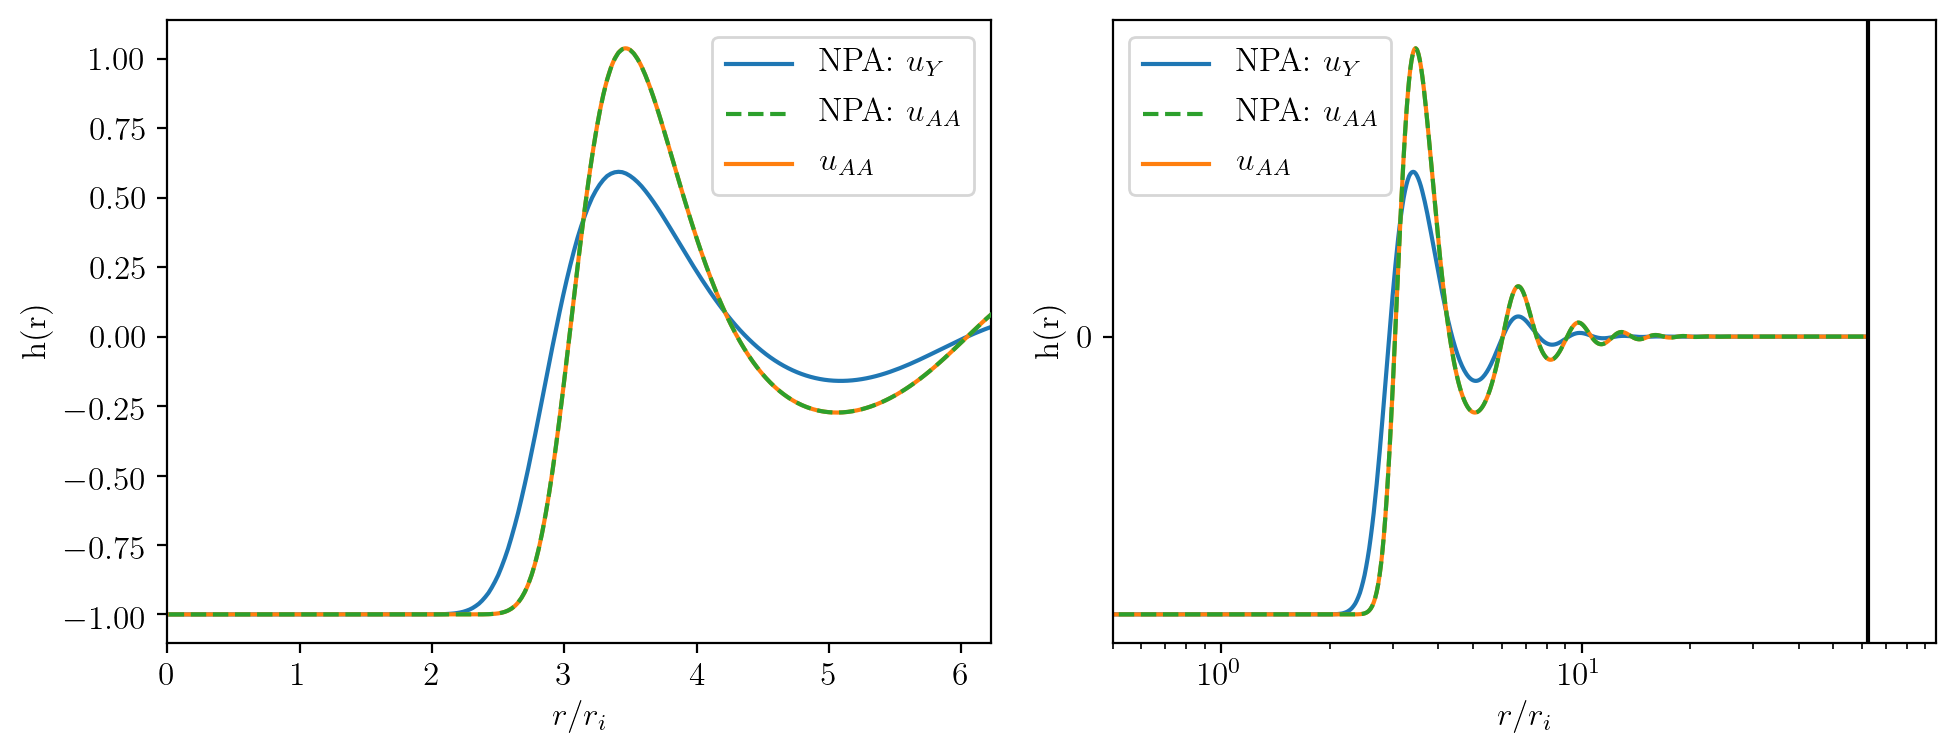

In [70]:
fig, axs  = plt.subplots(1,2,figsize=(10,4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# short_distance_weight = np.exp(-(0.08*npa.kTF*npa.grid.xs)**4)
for ax in axs:
    # ax.plot(npa.iet.r_array*rs, npa.iet.h_r_matrix[0,0], color=colors[0], label=r"NPA: $u_Y$")
    ax.plot(npa.grid.xs, npa.gii-1, color=colors[0], label=r"NPA: $u_Y$")
    ax.plot(npa_2.grid.xs, npa_2.gii-1,'--', color=colors[2], label=r"NPA: $u_{AA}$",zorder=10)
    ax.plot(aa.iet.r_array*rs, aa.iet.h_r_matrix[0,0],color=colors[1],  label=r"$u_{AA}$")
    # ax.plot(npa.grid.xs, short_distance_weight*(npa.gii-1),'--',color=colors[3],  label=r"$u_Y$ damped")
    			

    # ax.plot(aa.grid.xs, aa.gii-1,'--',color=colors[3],  label=r"$u_Y$")
    ax.axvline(aa.iet.r_array[-1]*rs,color='k')
    
ax = axs[0]
ax.set_xlabel(r"$r/r_i$",fontsize=12)
ax.set_ylabel("h(r)",fontsize=12)
ax.set_xlim(0,3*rs)

ax = axs[1]
ax.set_xlabel(r"$r/r_i$",fontsize=12)
ax.set_ylabel("h(r)",fontsize=12)
ax.set_xscale('log')
ax.set_xlim(0.5,None)
ax.set_yscale('symlog', linthresh=1e-6)
for ax in axs:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)


plt.tight_layout()



(<Figure size 4000x1600 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7e6a1d457be0>,
       dtype=object))

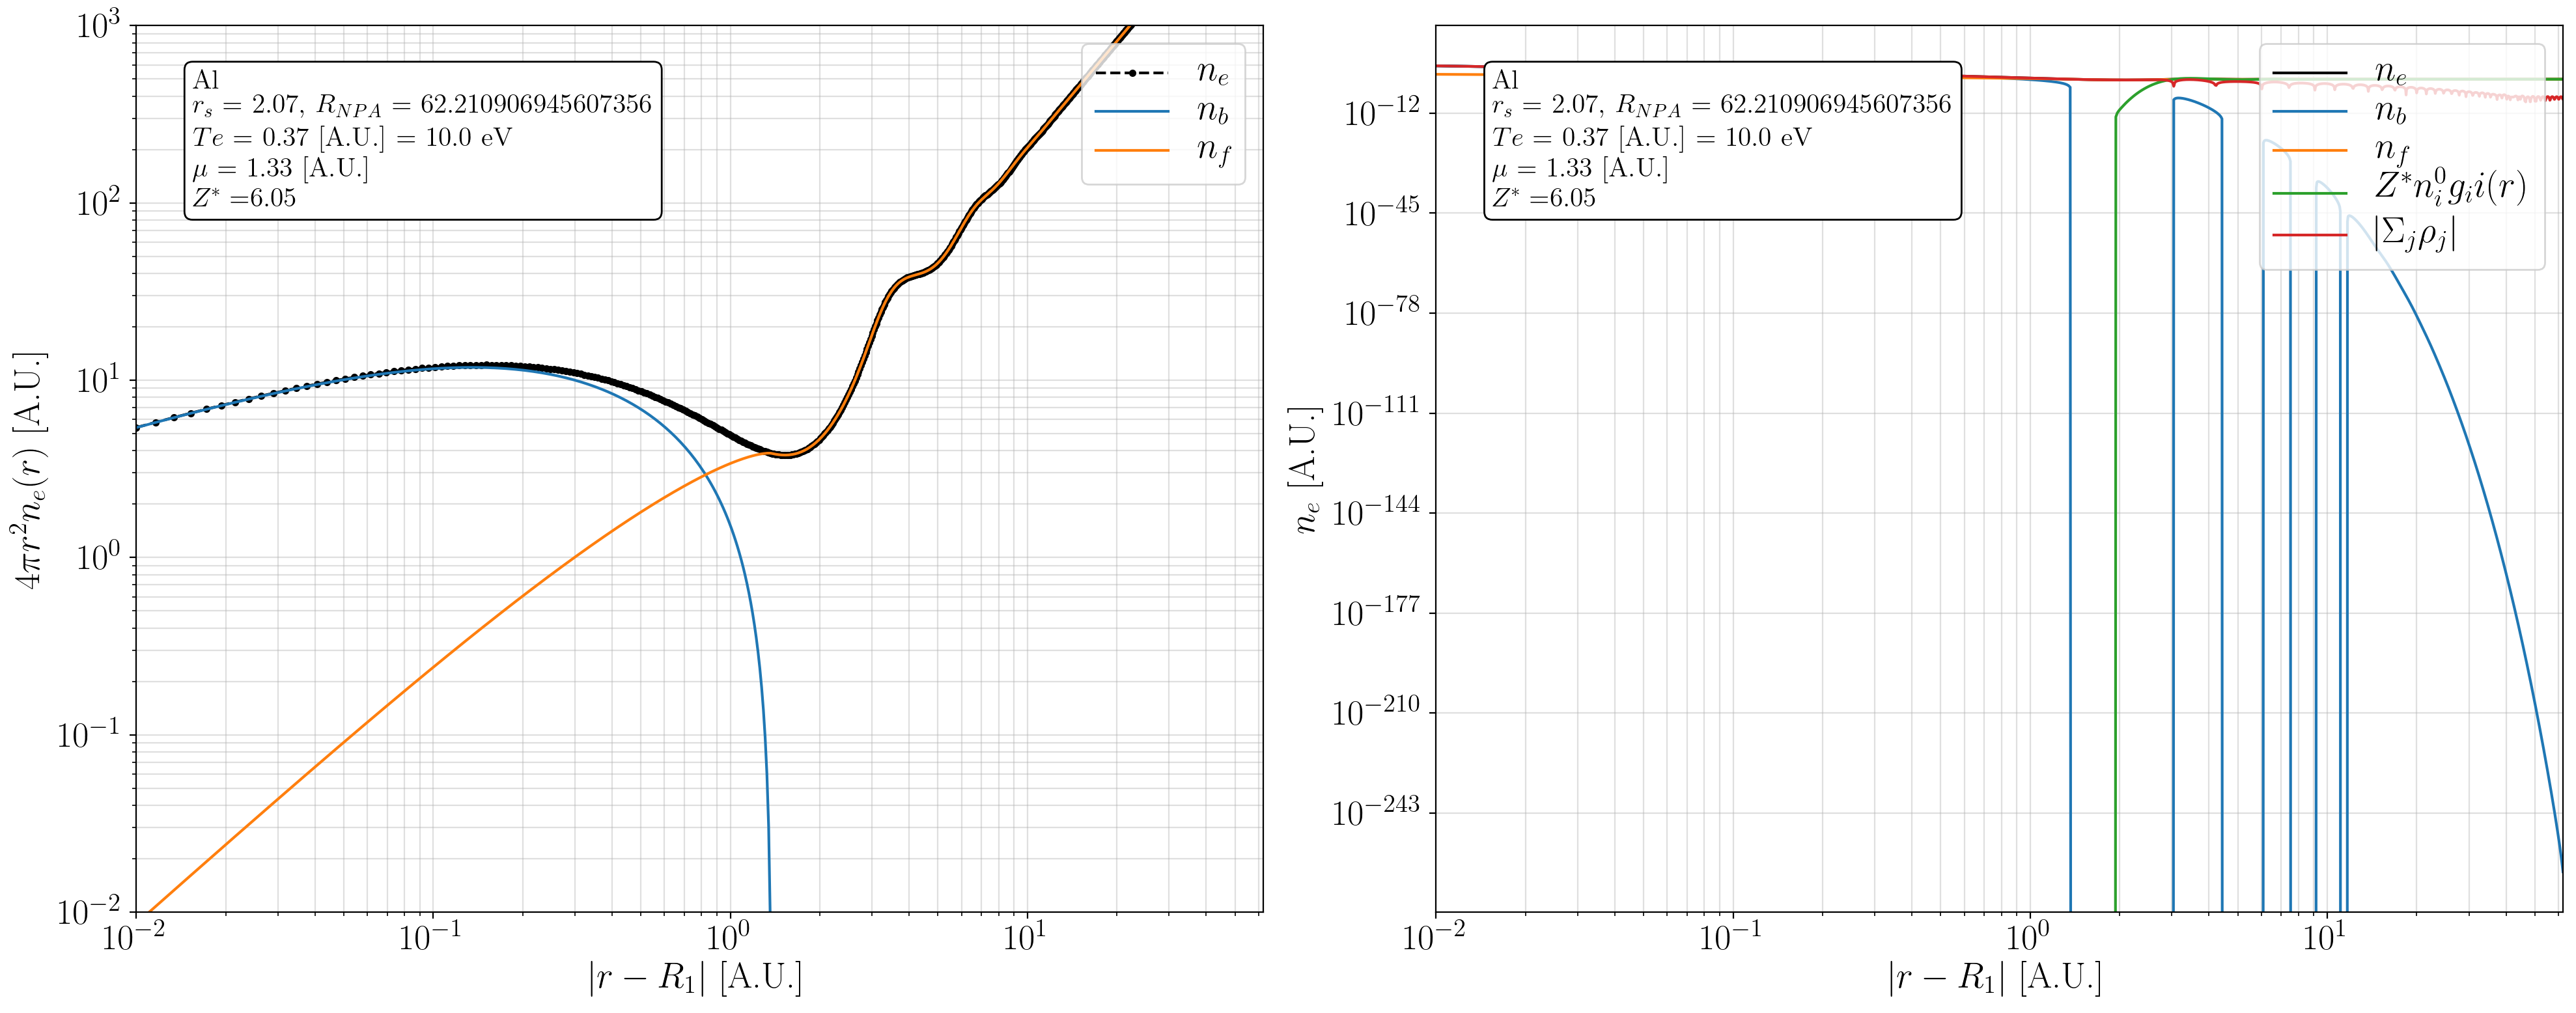

In [64]:
npa_2.make_plot_bound_free()

(<Figure size 4000x1600 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7e6a1d010640>,
       dtype=object))

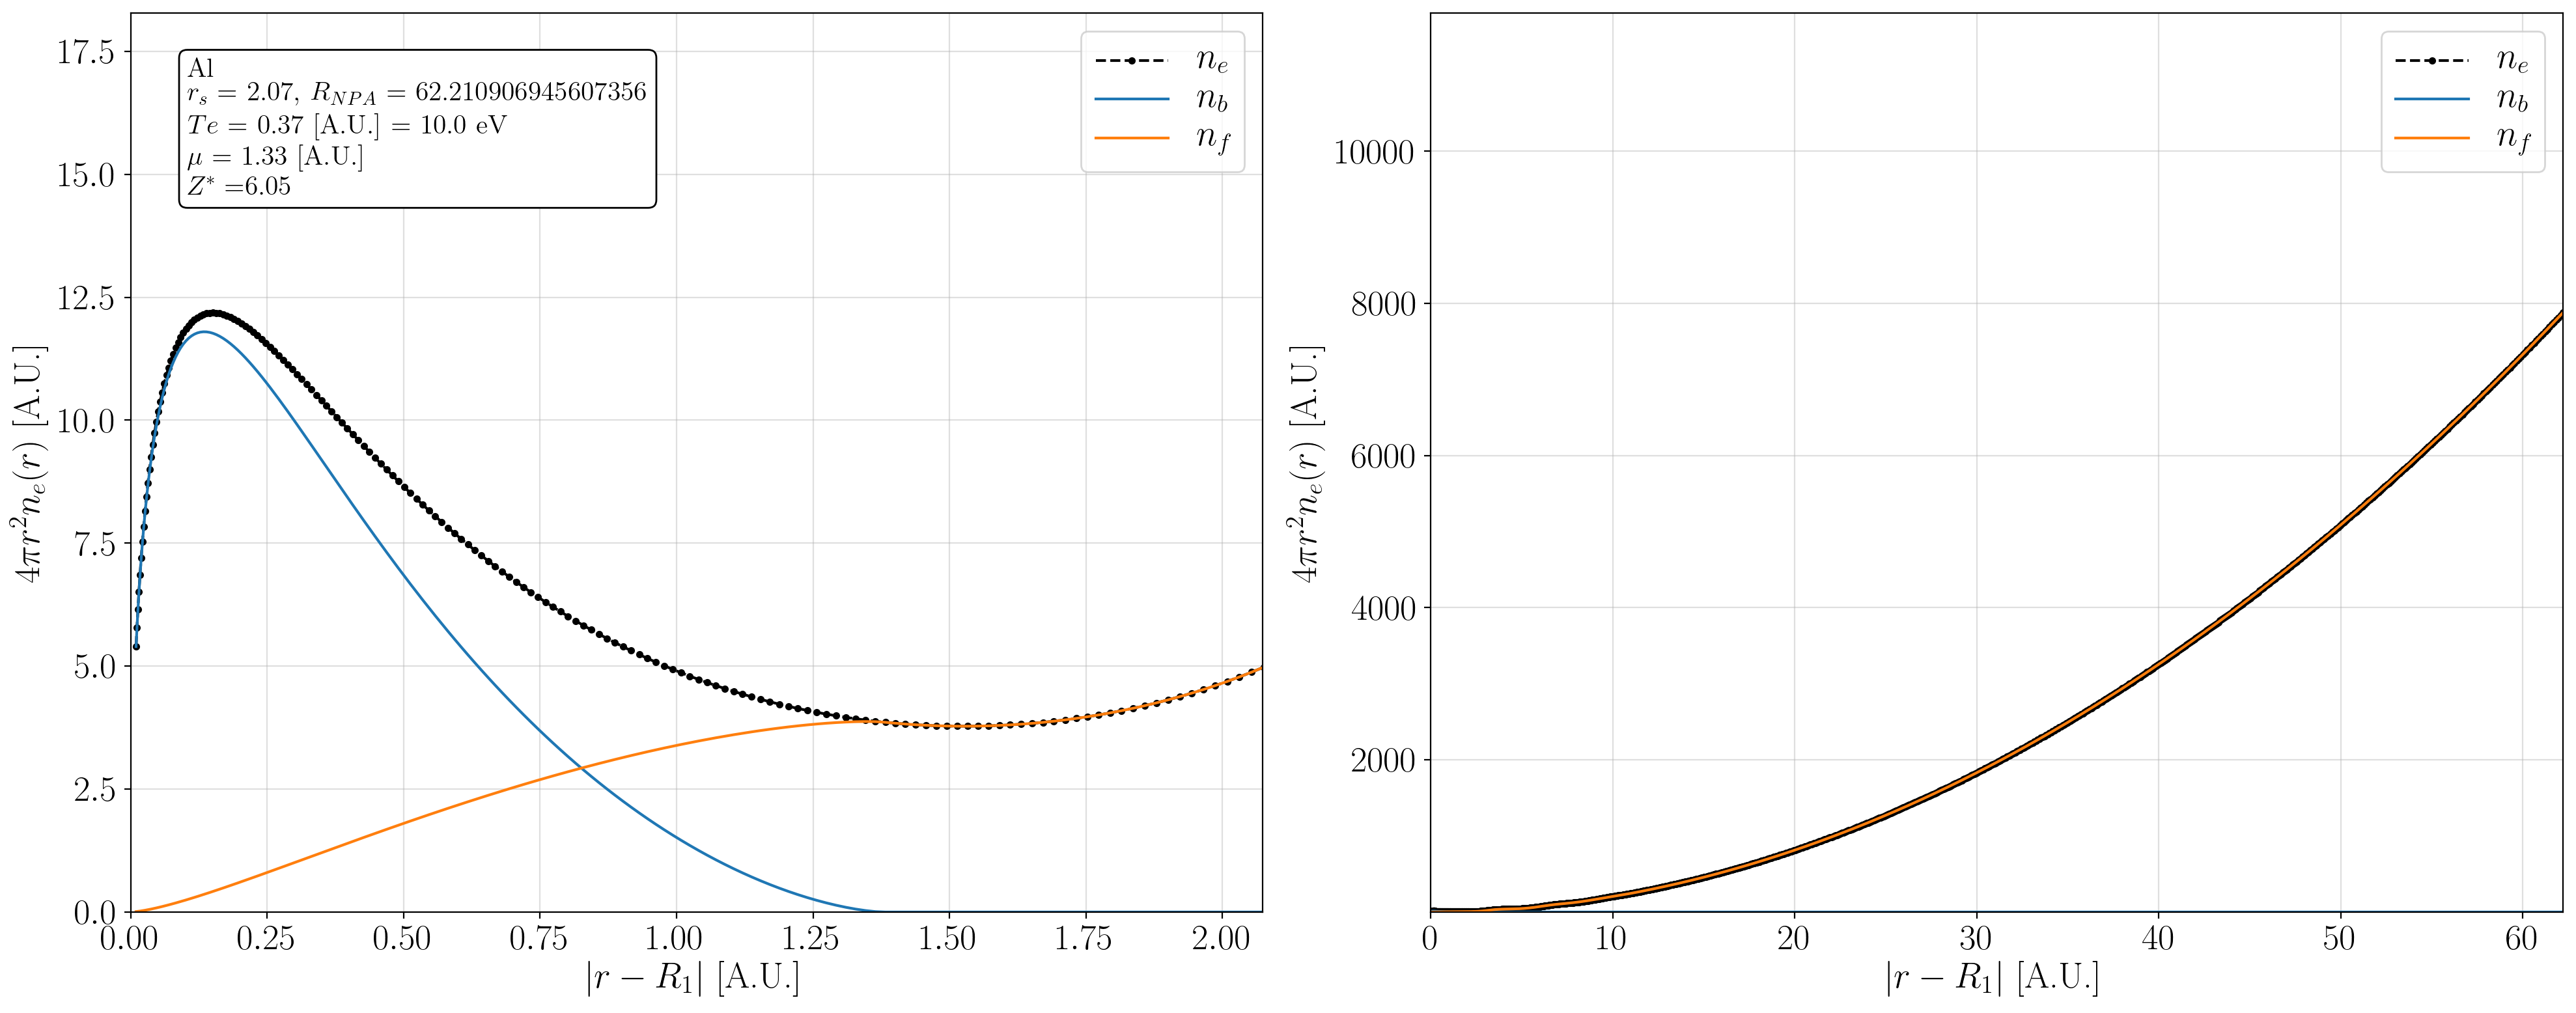

In [65]:
npa_2.make_charge_plot()

### Compare with Cleroin 2015 OFDFT

In [71]:
from pandas import read_csv

JC_2015_data = read_csv("Al_Clerouin_2015.txt", delim_whitespace=True, header=1)
JC_2015_data

,k[1/Ang],S_ii(k)
0,0.7108,0.02663
1,1.1760,0.03390
2,1.6420,0.05206
3,2.1150,0.09080
4,2.5880,0.18640
5,3.0520,0.43460
6,3.5120,1.12700
7,3.9890,1.77400
8,4.4580,1.36700
9,4.9260,0.98060


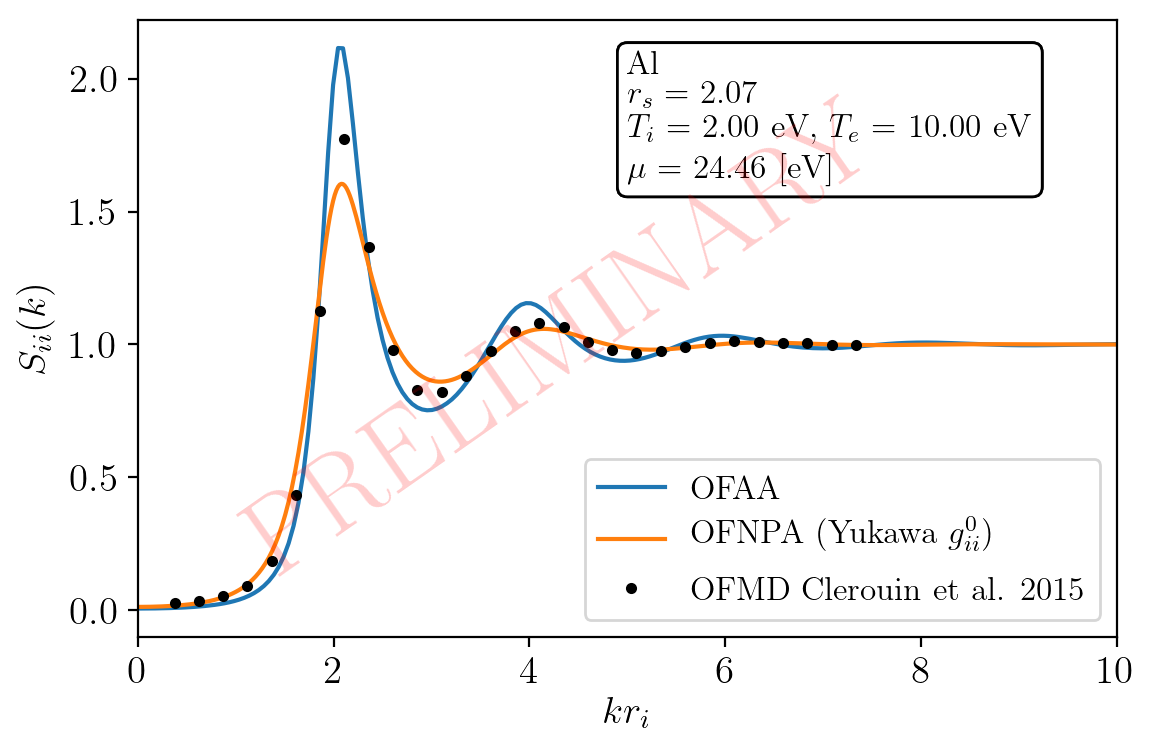

In [75]:
fig, ax = plt.subplots()

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(aa.iet.k_array/rs, aa.iet.S_k_matrix[0,0],'-', label="OFAA")
ax.plot(npa.iet.k_array/rs, npa.iet.S_k_matrix[0,0],'-', label=r"OFNPA (Yukawa $g^0_{ii}$)")
# ax.plot(npa_2.iet.k_array/rs, npa_2.iet.S_k_matrix[0,0],'-', label="OFNPA")

ax.plot(JC_2015_data['k[1/Ang]']/Angstrom_to_AU, JC_2015_data['S_ii(k)'],'k.', label="OFMD Clerouin et al. 2015" )

# make textbox
text = ("{0}\n".format(aa.name)+ 
    r"$r_s$ = " + "{0}\n".format(np.round(aa.rs,2))  +
        r"$T_i$ = " + "{0:0.2f} eV,   ".format(aa.Ti*AU_to_eV) +
        r"$T_e$ = " + "{0:0.2f} eV\n".format(aa.Te*AU_to_eV) +
        r"$\mu$ = " + "{0:0.2f} [eV]".format(aa.μ*AU_to_eV))

props = dict(boxstyle='round', facecolor='w')
ax.text(0.5,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=props)

# make textbox
text = ("{0}\n".format(aa.name)+ 
    r"$r_s$ = " + "{0}\n".format(np.round(aa.rs,2))  +
        r"$T_i$ = " + "{0:0.2f} eV,   ".format(aa.Ti*AU_to_eV) +
        r"$T_e$ = " + "{0:0.2f} eV\n".format(aa.Te*AU_to_eV) +
        r"$\mu$ = " + "{0:0.2f} [eV]".format(aa.μ*AU_to_eV))

props = dict(boxstyle='round', facecolor='w')
ax.text(0.5,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=props)
ax.text(0.1,0.1, 'PRELIMINARY', rotation=35,color='r',alpha=0.2,fontsize=40, transform=ax.transAxes)#, verticalalignment='top', horizontalalignment='left')

ax.set_xlim(0,10)
ax.set_xlabel(r"$k r_i$")
ax.set_ylabel(r"$S_{ii}(k)$")
ax.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig("Sii_Clerouin.png")